In [27]:
SOURCE_MODEL_CHCKPNT = 'microsoft/wavlm-base-plus'

In [28]:
!nvidia-smi

Sat Mar 25 05:45:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |   1167MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
!ls $SOURCE_MODEL_CHCKPNT* 2>/dev/null

In [30]:
%%capture
!pip install -U datasets transformers huggingface_hub evaluate

In [31]:
import random
import numpy as np
import matplotlib.pyplot as plt
import transformers
import datasets as hfds
import evaluate as hfeval
import huggingface_hub
from kaggle_secrets import UserSecretsClient
from IPython import display
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
print('Transformers', transformers.__version__)
print('Numpy', np.__version__)
print('Datasets', hfds.__version__)
!python -V

Transformers 4.27.3
Numpy 1.21.6
Datasets 2.10.1
Python 3.7.12


In [32]:
dataset = hfds.load_from_disk("/kaggle/input/0-9up-google-speech-commands-augmented-raw")
# dataset = hfds.load_dataset("mazkooleg/google_speech_commands_augmented_raw")
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 1095480
    })
    validation: Dataset({
        features: ['audio', 'label'],
        num_rows: 3368
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 3773
    })
})

In [33]:
label2id = {l: i for i, l in enumerate(dataset["train"].features["label"].names)}
id2label = {str(id): label for label, id in label2id.items()}
label2id

{'zero': 0,
 'one': 1,
 'two': 2,
 'three': 3,
 'four': 4,
 'five': 5,
 'six': 6,
 'seven': 7,
 'eight': 8,
 'nine': 9,
 '#unk#': 10,
 '#pub#': 11}

In [34]:
for _ in range(5):
  rand_idx = random.randint(0, len(dataset["train"])-1)
  example = dataset["train"][rand_idx]
  audio = example["audio"]
  print(f'Label: {id2label[str(example["label"])]}')
  print(f'Shape: {audio["array"].shape}, sampling rate: {audio["sampling_rate"]}')
  display.display(display.Audio(audio["array"], rate=audio["sampling_rate"]))
  print()

Label: eight
Shape: (16000,), sampling rate: 16000



Label: #pub#
Shape: (16000,), sampling rate: 16000



Label: one
Shape: (16000,), sampling rate: 16000



Label: nine
Shape: (16000,), sampling rate: 16000



Label: nine
Shape: (16000,), sampling rate: 16000


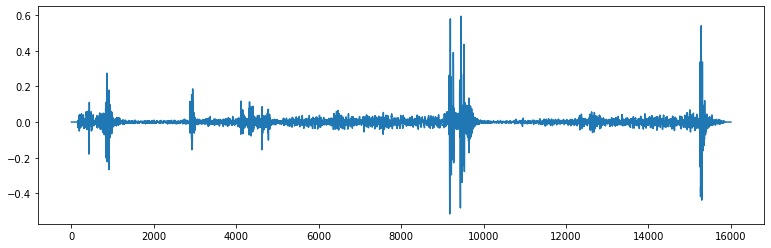

In [35]:
plt.rc('figure', figsize=(13, 4))
plt.plot(np.array(dataset['train'][0]['audio']['array']).T) and None

In [36]:
feature_extractor = AutoFeatureExtractor.from_pretrained(SOURCE_MODEL_CHCKPNT)
feature_extractor

Wav2Vec2FeatureExtractor {
  "do_normalize": false,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}

In [37]:
def preprocess_function(examples):
  inputs = feature_extractor(
    raw_speech = [x["array"] for x in examples["audio"]],
    sampling_rate=feature_extractor.sampling_rate, 
    max_length=int(feature_extractor.sampling_rate * 1.0) # seconds
  )
  inputs.update({'label': examples['label']})
  return inputs

In [38]:
# encoded_dataset = dataset.map(preprocess_function, remove_columns=["audio"], batched=True,
#                               cache_file_names={i: '/tmp/eds_cache_' + i for i in dataset.keys()})
# encoded_dataset

In [39]:
# from datasets import disable_caching
# disable_caching()
dataset.set_transform(preprocess_function)
dataset['test'][0].keys()

dict_keys(['input_values', 'attention_mask', 'label'])

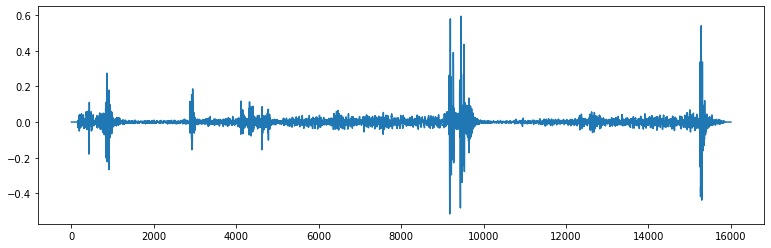

In [40]:
# plt.rc('figure', figsize=(10, 10))
# plt.imshow(np.array(dataset['train'][0]['input_values']).T)
plt.plot(np.array(dataset['train'][0]['input_values']).T)

In [41]:
model = AutoModelForAudioClassification.from_pretrained(
  SOURCE_MODEL_CHCKPNT,
  num_labels=len(id2label),
  label2id=label2id,
  id2label=id2label,
  ignore_mismatched_sizes=True
)

Some weights of WavLMForSequenceClassification were not initialized from the model checkpoint at microsoft/wavlm-base-plus and are newly initialized: ['classifier.bias', 'projector.weight', 'projector.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# huggingface_hub.login(UserSecretsClient().get_secret('hf-datasets-token'))

In [43]:
args = transformers.TrainingArguments(
  f"{SOURCE_MODEL_CHCKPNT}-ft",
  evaluation_strategy="epoch",
  save_strategy="epoch",
  learning_rate=1e-5,
  per_device_train_batch_size=32,
  gradient_accumulation_steps=4,
  per_device_eval_batch_size=32,
  num_train_epochs=5,
  warmup_ratio=0.1,
  logging_steps=10,
  load_best_model_at_end=True,
  metric_for_best_model="accuracy",
  report_to='none',
  remove_unused_columns=False,
#   push_to_hub=True,
)

In [44]:
metric = hfeval.load("accuracy")
def compute_metrics(eval_pred):
  """Computes accuracy on a batch of predictions"""
  predictions = np.argmax(eval_pred.predictions, axis=1)
  return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [45]:
trainer = transformers.Trainer(
  model,
  args,
  train_dataset=dataset["train"],
  eval_dataset=dataset["validation"],
  tokenizer=feature_extractor,
  compute_metrics=compute_metrics
)

In [ ]:
try:
  trainer.train(resume_from_checkpoint=True)
except ValueError:
  print('Training from scratch')
  trainer.train()

Training from scratch


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss


In [ ]:
 trainer.evaluate(dataset["test"])

In [ ]:
trainer.evaluate()

In [ ]:
# trainer.push_to_hub()

In [ ]:
# !cp -r facebook.bak/wav2vec2-base-ft/* facebook/wav2vec2-base-ft

In [1]:
#!rm -r *